In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

# Clustering Algorithms
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

# Evaluation Metrics for Clustering (Internal Validation)
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Dimensionality Reduction for Visualization (Optional but Recommended)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE # Often better for visualizing clusters

print("Libraries imported for Clustering Modeling.")

Libraries imported for Clustering Modeling.


In [6]:
# Define path to the processed features file
processed_data_dir = 'data_processed'
features_path = os.path.join(processed_data_dir, 'train_final_features.csv')

# Load the data
try:
    X = pd.read_csv(features_path)
    print("Processed features loaded successfully for clustering.")
    print(f"Features shape: {X.shape}")
except FileNotFoundError as e:
    print(f"Error loading processed features file: {e}")
    print("Ensure the feature engineering notebook (3_feature_engineering.ipynb) was run successfully and saved 'train_final_features.csv'.")
    raise
except Exception as e:
    print(f"An error occurred: {e}")
    raise

# # Optional: Load feature names if needed (CSV header should preserve them)
# feature_names_path = 'E:/GUVI/Projects/customer_conversion_analysis/models'
# try:
#    feature_names = joblib.load(feature_names_path)
#    # Sanitize feature names if needed, although clustering algorithms usually don't care
#    import re
#    def sanitize_feature_names_list(names):
#        return [re.sub(r'[\[\]<]', '_', str(name)) for name in names]
#    sanitized_feature_names = sanitize_feature_names_list(feature_names)
#    X.columns = sanitized_feature_names # Use sanitized names if necessary
#    print("Feature names loaded and assigned.")
# except FileNotFoundError:
#    print("Warning: feature_names.joblib not found. Relying on CSV header order.")


# --- IMPORTANT: Sample the data if it's very large ---
# Clustering algorithms like DBSCAN or AgglomerativeClustering can be computationally expensive.
# K-Means is generally faster, but visualization/evaluation on the full dataset might still be slow.
sample_size = 1000 # Adjust as needed based on performance and dataset size (e.g., 5000, 20000)
if len(X) > sample_size:
    print(f"\nSampling data down to {sample_size} rows for efficiency.")
    X_sample = X.sample(n=sample_size, random_state=42)
else:
    print("\nUsing full dataset for clustering.")
    X_sample = X.copy() # Use a copy to avoid modifying original X if needed later

print(f"Shape of data being used for clustering: {X_sample.shape}")

Processed features loaded successfully for clustering.
Features shape: (22910, 72)

Sampling data down to 1000 rows for efficiency.
Shape of data being used for clustering: (1000, 72)



--- K-Means Clustering: Finding Optimal K ---
Testing K=2...
  Silhouette Score: 0.1610
Testing K=3...
  Silhouette Score: 0.1979
Testing K=4...
  Silhouette Score: 0.2373
Testing K=5...
  Silhouette Score: 0.2270
Testing K=6...
  Silhouette Score: 0.2212
Testing K=7...
  Silhouette Score: 0.1978
Testing K=8...
  Silhouette Score: 0.2121
Testing K=9...
  Silhouette Score: 0.2195
Testing K=10...
  Silhouette Score: 0.2272


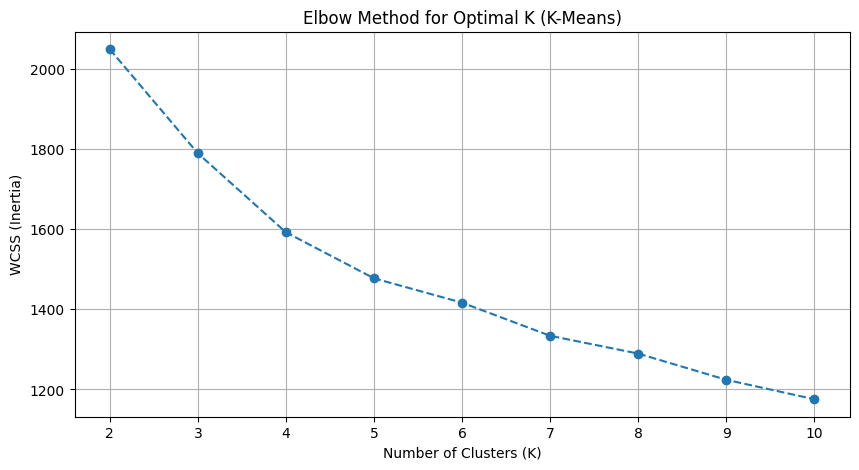

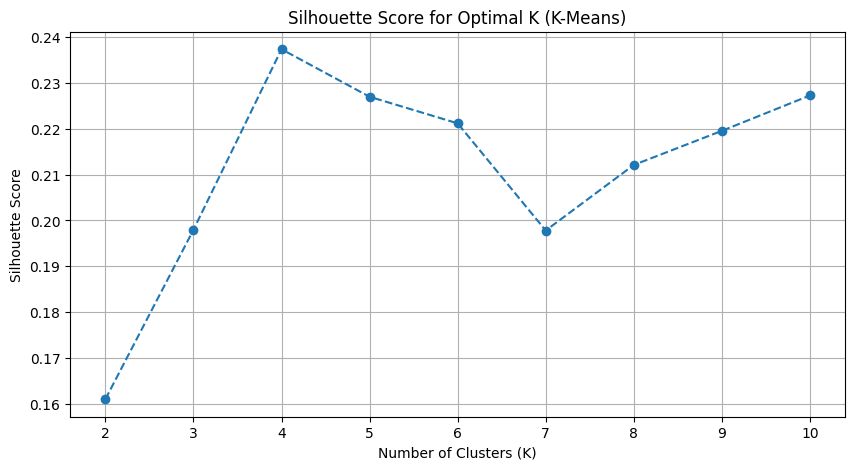

In [7]:
print("\n--- K-Means Clustering: Finding Optimal K ---")

# Use the Elbow Method (Within-Cluster Sum of Squares - WCSS)
wcss = []
silhouette_scores = []
k_range = range(2, 11) # Test K from 2 to 10 clusters

for k in k_range:
    print(f"Testing K={k}...")
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(X_sample)
    wcss.append(kmeans.inertia_) # Inertia is the WCSS

    # Calculate Silhouette Score (computationally more expensive)
    # Only calculate if dataset size is manageable, skip if too slow
    if X_sample.shape[0] < 20000: # Adjust threshold if needed
        try:
            score = silhouette_score(X_sample, kmeans.labels_)
            silhouette_scores.append(score)
            print(f"  Silhouette Score: {score:.4f}")
        except Exception as e:
            print(f"  Could not calculate Silhouette Score for k={k}: {e}")
            silhouette_scores.append(np.nan) # Append NaN if calculation fails
    else:
        silhouette_scores.append(np.nan)
        print("  Skipping Silhouette Score calculation due to dataset size.")


# Plot the Elbow Method graph
plt.figure(figsize=(10, 5))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K (K-Means)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Inertia)')
plt.grid(True)
plt.show()

# Plot Silhouette Scores if calculated
if not all(np.isnan(silhouette_scores)):
    plt.figure(figsize=(10, 5))
    plt.plot(k_range, silhouette_scores, marker='o', linestyle='--')
    plt.title('Silhouette Score for Optimal K (K-Means)')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.show()

In [9]:
# --- Fit K-Means with the chosen optimal K ---
optimal_k = 4 # <<< CHANGE THIS based on your Elbow/Silhouette analysis
print(f"\nFitting K-Means with K={optimal_k}...")

kmeans_final = KMeans(n_clusters=optimal_k, init='k-means++', n_init=10, random_state=42)
kmeans_labels = kmeans_final.fit_predict(X_sample) # Use fit_predict

# Add cluster labels to the sample data
X_sample_clustered = X_sample.copy()
X_sample_clustered['kmeans_cluster'] = kmeans_labels

print(f"\nK-Means fitting complete. Cluster distribution:")
print(X_sample_clustered['kmeans_cluster'].value_counts())

# Evaluate the chosen K
try:
    final_silhouette = silhouette_score(X_sample, kmeans_labels)
    final_db_score = davies_bouldin_score(X_sample, kmeans_labels)
    print(f"\nEvaluation metrics for K={optimal_k}:")
    print(f"  Silhouette Score: {final_silhouette:.4f}") # Higher is better
    print(f"  Davies-Bouldin Index: {final_db_score:.4f}") # Lower is better (closer to 0)
except Exception as e:
     print(f"\nCould not calculate final evaluation metrics: {e}")

# --- Save the final K-Means model ---
output_dir = 'models'
os.makedirs(output_dir, exist_ok=True)
kmeans_model_path = os.path.join(output_dir, 'kmeans_model.joblib')
joblib.dump(kmeans_final, kmeans_model_path)
print(f"\nFinal K-Means model (k={optimal_k}) saved to: {kmeans_model_path}")


Fitting K-Means with K=4...

K-Means fitting complete. Cluster distribution:
kmeans_cluster
1    345
3    273
0    214
2    168
Name: count, dtype: int64

Evaluation metrics for K=4:
  Silhouette Score: 0.2373
  Davies-Bouldin Index: 1.7120

Final K-Means model (k=4) saved to: models\kmeans_model.joblib



--- Visualizing K-Means Clusters using PCA ---


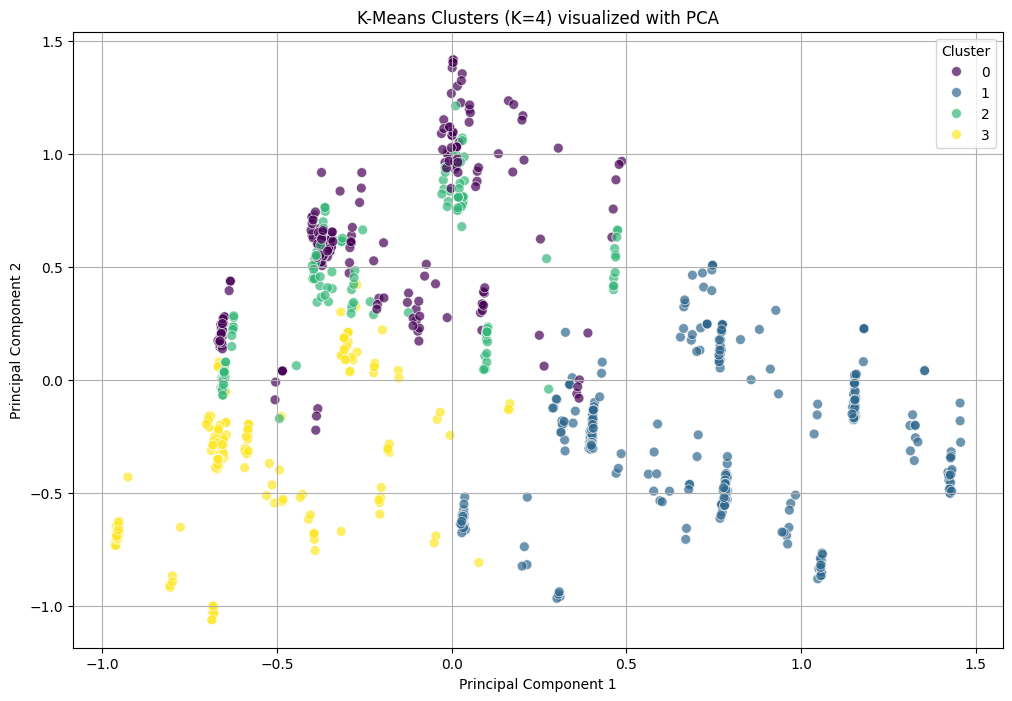

In [10]:
print("\n--- Visualizing K-Means Clusters using PCA ---")

# Reduce dimensionality using PCA
pca = PCA(n_components=2, random_state=42)
X_sample_pca = pca.fit_transform(X_sample) # Use X_sample (features only)

# Add PCA components and cluster labels to a DataFrame for plotting
df_pca = pd.DataFrame(X_sample_pca, columns=['PCA1', 'PCA2'], index=X_sample.index)
df_pca['kmeans_cluster'] = kmeans_labels # Use the labels from the final model

# Create scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='kmeans_cluster', data=df_pca, palette='viridis', s=50, alpha=0.7)
plt.title(f'K-Means Clusters (K={optimal_k}) visualized with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# --- Optional: Visualize using t-SNE (often better for cluster separation, but slower) ---
# print("\n--- Visualizing K-Means Clusters using t-SNE (might take time) ---")
# tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300) # Adjust parameters if needed
# X_sample_tsne = tsne.fit_transform(X_sample)
#
# df_tsne = pd.DataFrame(X_sample_tsne, columns=['TSNE1', 'TSNE2'], index=X_sample.index)
# df_tsne['kmeans_cluster'] = kmeans_labels
#
# plt.figure(figsize=(12, 8))
# sns.scatterplot(x='TSNE1', y='TSNE2', hue='kmeans_cluster', data=df_tsne, palette='viridis', s=50, alpha=0.7)
# plt.title(f'K-Means Clusters (K={optimal_k}) visualized with t-SNE')
# plt.xlabel('t-SNE Component 1')
# plt.ylabel('t-SNE Component 2')
# plt.legend(title='Cluster')
# plt.grid(True)
# plt.show()


--- Analyzing Cluster Characteristics (K-Means) ---
Mean feature values per K-Means cluster (Scaled Data):
kmeans_cluster                     0         1         2         3
session_length              0.036372  0.029135  0.041360  0.021487
unique_main_categories      0.311526  0.273430  0.285714  0.217338
unique_models_viewed        0.036483  0.029179  0.044004  0.022738
unique_colours              0.212437  0.145373  0.214744  0.157791
avg_price_viewed            0.356190  0.434474  0.318648  0.503029
max_price_viewed            0.521028  0.639312  0.480841  0.637134
model_photography_<lambda>  0.172897  0.107246  0.196429  0.065934
price_2_<lambda>            0.345794  0.539130  0.333333  0.223443
country_first_1             0.000000  0.000000  0.000000  0.000000
country_first_2             0.000000  0.000000  0.000000  0.003663
country_first_3             0.000000  0.000000  0.000000  0.000000
country_first_4             0.000000  0.000000  0.000000  0.000000
country_first_5      

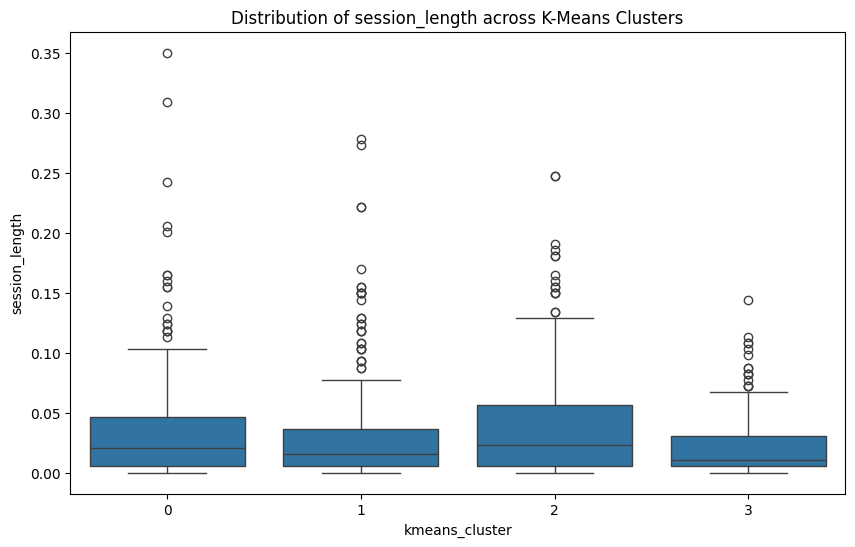

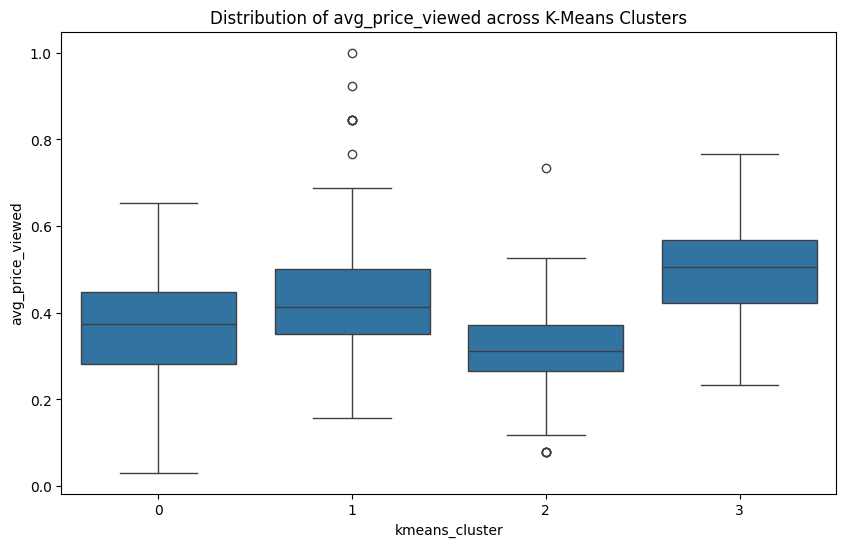

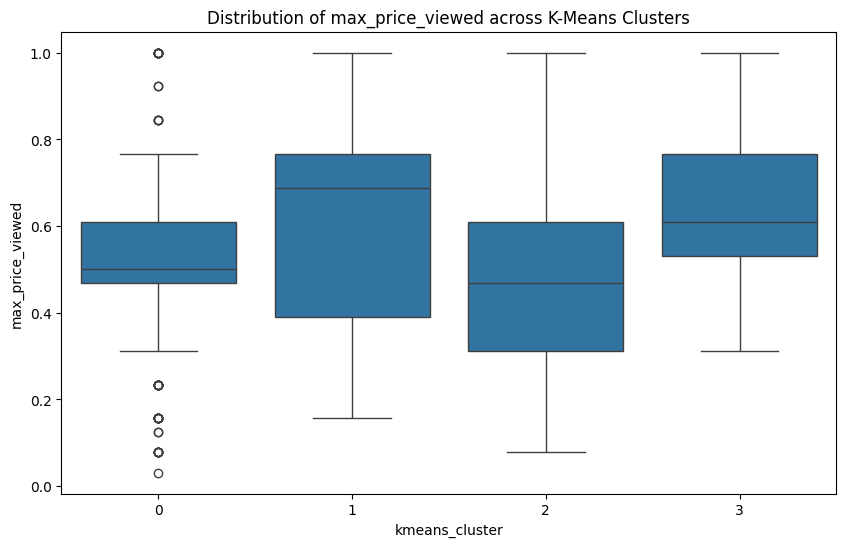

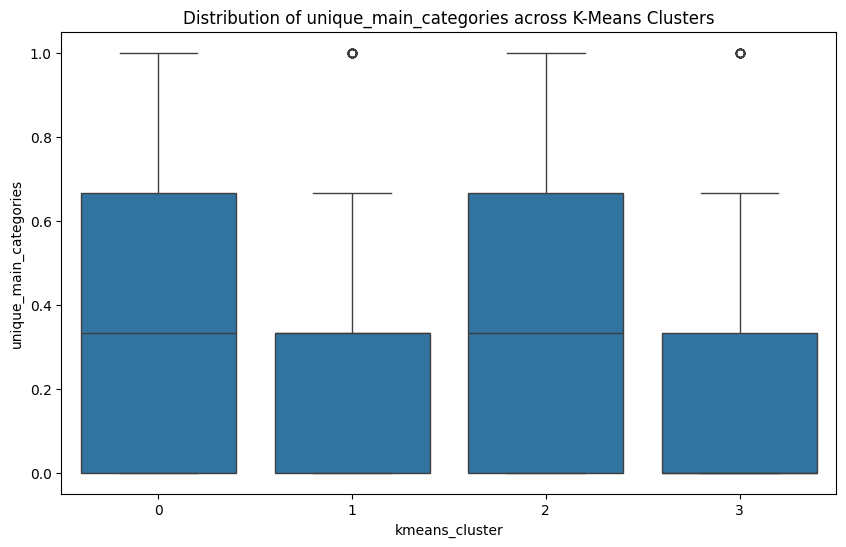

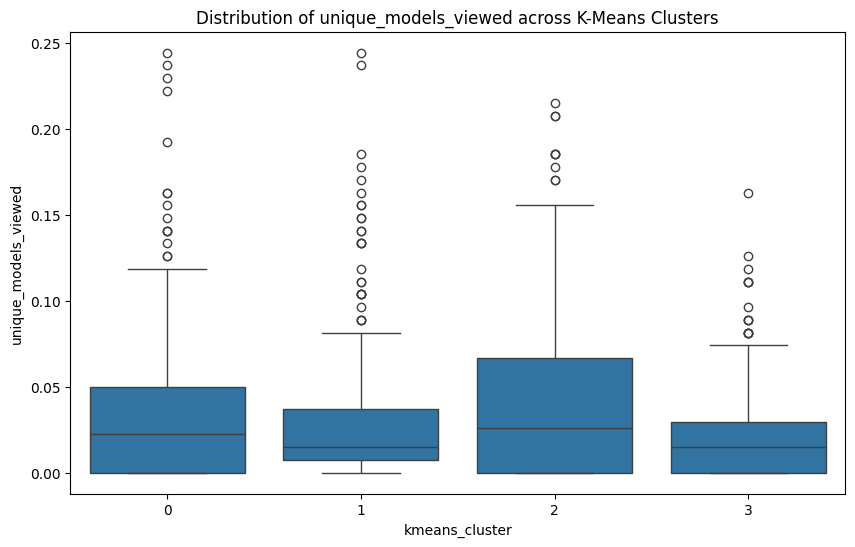

In [12]:
print("\n--- Analyzing Cluster Characteristics (K-Means) ---")

# Calculate the mean of original (or scaled) features for each cluster
# It's often more interpretable to use the data BEFORE scaling/encoding for this,
# but we'll use the scaled data (X_sample_clustered) here as it's readily available.
# You might need to map feature names back if needed.

cluster_centers_scaled = X_sample_clustered.groupby('kmeans_cluster').mean()

print("Mean feature values per K-Means cluster (Scaled Data):")
# Display with formatting for readability
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):
    print(cluster_centers_scaled.T) # Transpose for better column view


# --- Optional: Inverse transform cluster centers to original scale ---
# This requires the preprocessor object and careful handling of feature names
preprocessor_path = 'models'
try:
    preprocessor = joblib.load(preprocessor_path)
    # Get numerical and categorical feature names used by the preprocessor
    num_features = preprocessor.transformers_[0][2]
    cat_features = preprocessor.transformers_[1][2]
    # Get the scaler from the numerical transformer
    scaler = preprocessor.named_transformers_['num'].named_steps['scaler']

    # Create a DataFrame matching the structure expected by the preprocessor
    # Need to be careful about the order and number of columns after OHE
    # This part is complex and error-prone. Simpler approach might be to re-run aggregation on original data per cluster.

    print("\n(Skipping inverse transform for now due to complexity - analyze scaled centers)")

except FileNotFoundError:
    print("\nPreprocessor not found, cannot inverse transform cluster centers.")
except Exception as e:
    print(f"\nError during inverse transform attempt: {e}")


# --- Simpler Analysis: Key Feature Comparison ---
# Select a few key numerical features and compare their means across clusters
key_features_to_analyze = [
     'session_length', 'avg_price_viewed', 'max_price_viewed',
     'unique_main_categories', 'unique_models_viewed'
     # Add other features of interest, make sure they exist in X_sample_clustered after potential sanitization
]
# Filter for features that actually exist in the dataframe
key_features_to_analyze = [f for f in key_features_to_analyze if f in X_sample_clustered.columns]


print(f"\nComparing means of key features across K-Means clusters (Scaled Data):")
print(X_sample_clustered.groupby('kmeans_cluster')[key_features_to_analyze].mean())

# Visualize distributions of key features per cluster
print("\nVisualizing key feature distributions per cluster...")
for feature in key_features_to_analyze:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='kmeans_cluster', y=feature, data=X_sample_clustered)
    plt.title(f'Distribution of {feature} across K-Means Clusters')
    plt.show()